<h1 style="text-align:center;">IDFC FAME 2.0 ROUND 2 CODES</h1>


<h2 style="text-align:center;">Exploratory Data Analysis</h2>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
df = pd.read_csv('Training data file.csv', index_col='Customer_No')
df_test = pd.read_csv('Validation Data file.csv', index_col='Customer_No')
df1 = df.copy()
col = df.columns

In [3]:
df.head()

,N_Default_L3m,Branch_Code,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,Max_Ratio_OC_Pending_POS,N_PosBkt_L3m,CoAp_Income,Ever_Default_L12M,Perc_Paymode_Online,...,Birth_Year,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,Total_Field_Trails,Total_Resolved,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
Customer_No,,,,,,,,,,,,,,,,,,,,,
1,3,61749,38,100.0,5,NaN,0.0,NaN,Yes,0.285714,...,1977,19.0,0.750,46,NaN,NaN,0,5527.0,15,0
2,1,30831,68,100.0,1,NaN,0.0,NaN,Yes,0.000000,...,1990,2.0,0.500,33,NaN,NaN,0,12104.0,2,0
3,1,56708,39,50.0,-3,NaN,0.0,NaN,Yes,0.200000,...,1995,25.0,1.000,28,NaN,0.0,1,153179.0,8,0
4,0,43551,76,NaN,0,NaN,0.0,NaN,No,0.000000,...,1997,0.0,NaN,26,NaN,NaN,2,181589.0,6,0
5,3,15287,23,33.0,11,NaN,0.0,NaN,Yes,0.250000,...,1995,19.0,0.375,28,NaN,NaN,1,10661.0,8,0


Function for Missing values in each column

In [4]:
def missingdata_percentage(df, per=0):
    missing = pd.DataFrame(columns=['category','percentage'])
    for col in df.columns:
        if df[col].isna().values.any():
            count = df[col].isna().sum()
            percentage = 100*df[col].isna().sum()/df.shape[0]
            if percentage>=per:
              missing = missing.append({'category' : col, 'percentage' : percentage, 'count' : int(count)}, ignore_index=True)
    missing.sort_values(by=['percentage'], inplace=True, ascending=False)
    return missing

In [5]:
train_data_Miss = missingdata_percentage(df)
train_data_Miss

,category,percentage,count
3,CoAp_Income,94.931879,77135.0
1,Max_Ratio_OC_Pending_POS,89.407160,72646.0
6,Total_Field_Trails,67.335360,54712.0
7,Total_Resolved,61.911560,50305.0
5,Perc_Paymode_Cheq_Fail,28.893702,23477.0
0,Max_Perc_Def_Chg_Pending,25.941196,21078.0
2,N_PosBkt_L3m,6.569604,5338.0
8,Max_Loan_Balance_Others,0.419677,341.0
4,Max_DPD_L3m,0.299066,243.0


In [6]:
test_data_Miss = missingdata_percentage(df_test)
test_data_Miss

,category,percentage,count
3,CoAp_Income,95.060045,28576.0
1,Max_Ratio_OC_Pending_POS,89.551246,26920.0
6,Total_Field_Trails,67.619174,20327.0
7,Total_Resolved,62.117029,18673.0
5,Perc_Paymode_Cheq_Fail,28.638435,8609.0
0,Max_Perc_Def_Chg_Pending,24.513489,7369.0
2,N_PosBkt_L3m,6.157480,1851.0
4,Max_DPD_L3m,0.392535,118.0
8,Max_Loan_Balance_Others,0.372576,112.0


Training and test data both have similar null value distribution so we can confirm that there are no discrapancies in given data.<br>
Lets check Target_flag distribution.

In [8]:
df['Target_Flag'].value_counts()

0    71469
1     9784
Name: Target_Flag, dtype: int64

### Let's start filling missing values in descending order.

### Handling "CoAp_Income"
* Upon closer inspection "CoAp_Income"(income of co-applicant) column looks like a optional entry and hence so many missing values. 
* 95% of them are missing values so they won't add any value to the data hence we can drop this column.




### Handling "Max_Ratio_OC_Pending_POS"

In [7]:
count = df['Max_Ratio_OC_Pending_POS'].value_counts()[0]
count

249

* Next "Max_Ratio_OC_Pending_POS" column also have 90% of missing values, most of these values are between 0 and 1.<br>
 -->Although there are 249 0's in dataset so they might correspond to people who paid their overdue charges.<br>--> And remaining null values most likely means these people didn't had any overdue charges to begin with. <br>
 -->So its a good idea to assume these values to be zero.<br>
-->But let's analyze further.

In [8]:
#Let's see distribution of target variable when Max_Ratio_OC_Pending_POS is 0.
df['Target_Flag'][df['Max_Ratio_OC_Pending_POS'] == 0].value_counts()

0    195
1     54
Name: Target_Flag, dtype: int64

In [11]:
# 22% of them corresponds to default customer

# Now lets see distribution of target when they are null.
df['Target_Flag'][df['Max_Ratio_OC_Pending_POS'].isna()].value_counts()

0    65165
1     7481
Name: Target_Flag, dtype: int64

In [9]:
# 10% of missing values have defaulted customers.

# Now lets see what percent of people have overdue charges pending and they defaulted.
cnt_with_oc_and_default = df[(df['Max_Ratio_OC_Pending_POS'] > 0 ) & (df['Target_Flag']== 1)].shape[0]
default_cnt = df[(df['Target_Flag']== 1)].shape[0]
oc_more_than_zero = df[(df['Max_Ratio_OC_Pending_POS'] > 0)].shape[0]


In [10]:
ratio_of_oc_and_default = (cnt_with_oc_and_default/oc_more_than_zero)
default_cnt, oc_more_than_zero, cnt_with_oc_and_default, ratio_of_oc_and_default

(9784, 8358, 2249, 0.26908351280210574)

From above data we see that 27% of people who have overdue charges have defaulted, that means other 73% of people are not defaulters.<br>
Also 0 doesn't necessarily confirms that person will not commit default. <br>
We have two choices either assume null values to be zero or drop these column. <br>
We will try both and later see what works best.


#### Now lets examine null values of "Total_field_trials" and "Total_resolved"

In [14]:
'''def find_col_relation_with_target(df, col, value = 0):
    Valuecount_col_is_value = df['Target_Flag'][df[col] == value].value_counts()
    Valuecount_col_is_null = df['Target_Flag'][df[col].isna()].value_counts()
    null_without_default_last_12_month = df[col].isna()[df['Ever_Default_L12M'] == 'No'].sum()
    null_with_default_last_12_month = df[col].isna()[df['Ever_Default_L12M'] == 'Yes'].sum()
    null_without_default_last_3_month = df[col].isna()[df['N_Default_L3m'] == 'No'].sum()
    null_with_default_last_3_month = df[col].isna()[df['N_Default_L3m'] == 'Yes'].sum()
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", Valuecount_col_is_value)
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS NULL VALUES:", Valuecount_col_is_null)
    print("NULL VALUES DISTRIBUTION WITHOUT DEFAULT IN LAST ", null_without_default_last_12_month)
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", null_with_default_last_12_month)
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", null_without_default_last_3_month)
    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", null_with_default_last_3_month)'''

'def find_col_relation_with_target(df, col, value = 0):\n    Valuecount_col_is_value = df[\'Target_Flag\'][df[col] == value].value_counts()\n    Valuecount_col_is_null = df[\'Target_Flag\'][df[col].isna()].value_counts()\n    null_without_default_last_12_month = df[col].isna()[df[\'Ever_Default_L12M\'] == \'No\'].sum()\n    null_with_default_last_12_month = df[col].isna()[df[\'Ever_Default_L12M\'] == \'Yes\'].sum()\n    null_without_default_last_3_month = df[col].isna()[df[\'N_Default_L3m\'] == \'No\'].sum()\n    null_with_default_last_3_month = df[col].isna()[df[\'N_Default_L3m\'] == \'Yes\'].sum()\n    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", Valuecount_col_is_value)\n    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS NULL VALUES:", Valuecount_col_is_null)\n    print("NULL VALUES DISTRIBUTION WITHOUT DEFAULT IN LAST ", null_without_default_last_12_month)\n    print("vALUE COUNTS OF TARGET FLAGS WHEN COLUMN HAS VALUES:", null_with_default_last_12_month)\n    

In [12]:
col

Index(['N_Default_L3m', 'Branch_Code', 'Max_Utilization',
       'Max_Perc_Def_Chg_Pending', 'N_Family_Member',
       'Max_Ratio_OC_Pending_POS', 'N_PosBkt_L3m', 'CoAp_Income',
       'Ever_Default_L12M', 'Perc_Paymode_Online', 'Perc_Repay_Fail',
       'Birth_Year', 'Max_DPD_L3m', 'Perc_Paymode_Cheq_Fail', 'Age',
       'Total_Field_Trails', 'Total_Resolved', 'N_Enq_L9m',
       'Max_Loan_Balance_Others', 'N_WorkEx_Yr', 'Target_Flag'],
      dtype='object')

In [13]:
#Count of null values:
df['Total_Field_Trails'].isna().sum(), df['Total_Resolved'].isna().sum()

(54712, 50305)

In [16]:
df.groupby('Total_Field_Trails')['Target_Flag'].value_counts().reset_index(name='Count')

,Total_Field_Trails,Target_Flag,Count
0,0.0,0,16480
1,0.0,1,1706
2,1.0,0,4947
3,1.0,1,1046
4,2.0,0,1421
5,2.0,1,304
6,3.0,0,477
7,3.0,1,90
8,4.0,0,41
9,4.0,1,8


In [18]:
# Distribution of null values:
df['Total_Field_Trails'].value_counts(), df['Total_Resolved'].value_counts()

(0.0    18186
 1.0     5993
 2.0     1725
 3.0      567
 4.0       49
 5.0       13
 6.0        6
 9.0        1
 7.0        1
 Name: Total_Field_Trails, dtype: int64,
 1.0    15255
 2.0     7032
 3.0     4881
 0.0     3780
 Name: Total_Resolved, dtype: int64)

In [19]:
# Checking occurences of null values in both the fields simultaneously:
checking_common_occurences = df[(df['Total_Field_Trails'].isna() ) & (df['Total_Resolved'].isna())].shape[0]
checking_common_occurences

50305

* Now since there a lot of null values we can solve them using some common sense.
* First if there are lots of null amount of "Total_Field_Trails" it strongly indicates 0 field visits.
* Also above code shows that all the null values in "Total_Resolved" is when "Total_Field_Trails" is null as well.
* But in "Total_Resolved" column it doesn't tells us if Customer was visited or not.
* So we can take all the null value from total_resolved column as another value, let's say "not_visited".

We can also try by removing these columns.
Its a thumb rule to drop all the columns when there are more than 40% of null values.

In [18]:
df['Total_Field_Trails'].corr(df['Total_Resolved'])

0.17398498482556185

### Now lets look at the 'Perc_Paymode_Cheq_Fail' column.

<Axes: >

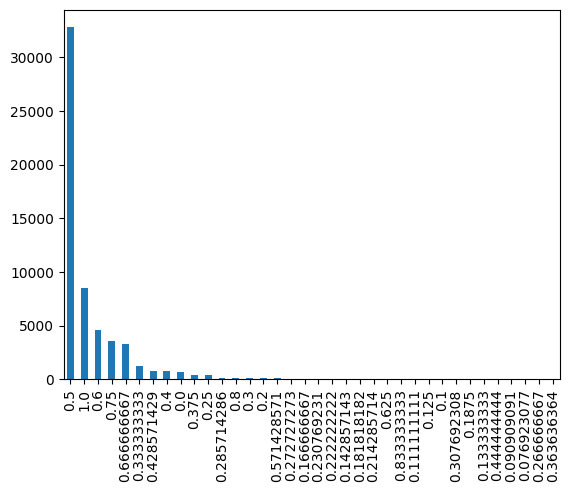

In [19]:
def_chg_perc = df['Perc_Paymode_Cheq_Fail'].value_counts()[df['Perc_Paymode_Cheq_Fail'].value_counts() >= 0]
def_chg_perc.plot(kind='bar')

<Axes: >

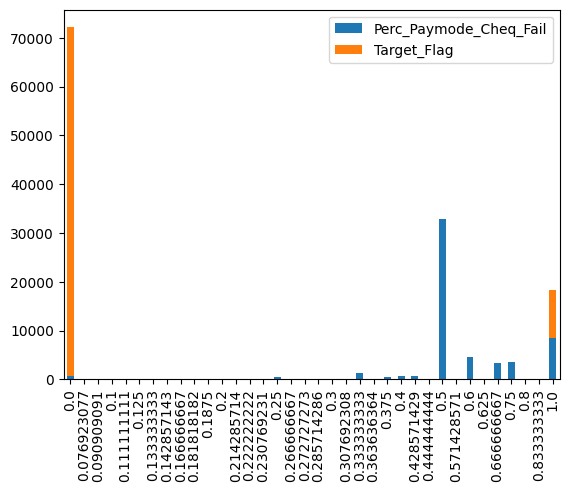

In [20]:
target_distribution = df['Target_Flag'].value_counts()
# Create a DataFrame with both distributions
data = pd.DataFrame({'Perc_Paymode_Cheq_Fail': def_chg_perc, 'Target_Flag': target_distribution})

# Create a stacked bar graph
data.plot(kind='bar', stacked=True)

In [ ]:
df['Perc_Paymode_Cheq_Fail'].value_counts()[0.0]

710

* We see that some of the values are 0 thus it means that customer with null values have never attempted to pay via cheque.

Although there is ambiguity its safe to assume 0 inplace of null values.

---

Now lets find some relation between Payment methods and payment failures.

Now lets explore "Max_Perc_Def_Chg_Pending" column:
1. Firstly this column signifies the maximum percentage of default charges pending.

Number of null values:

In [ ]:
null_perc_def_chg = df['Max_Perc_Def_Chg_Pending'].isna().sum()
null_perc_def_chg

21078

Null values may mean that person never had any default charge. So lets check amount of customer with default in past 12 months and Max_Perc_Def_Chg_Pending as null.


In [ ]:
null_without_default = df['Max_Perc_Def_Chg_Pending'].isna()[df['Ever_Default_L12M'] == 'No'].sum()
null_with_default = df['Max_Perc_Def_Chg_Pending'].isna()[df['Ever_Default_L12M'] == 'Yes'].sum()
null_with_default/null_perc_def_chg, null_without_default/null_perc_def_chg

(0.19944966315589716, 0.8005503368441028)

We can see that customer without default in last 12 months have 80% of the null values and rest does have default.
It is safe to assume that null values means customer never had any default in last 12 months.<br>
----> So we can take null values to be another category.

<Axes: >

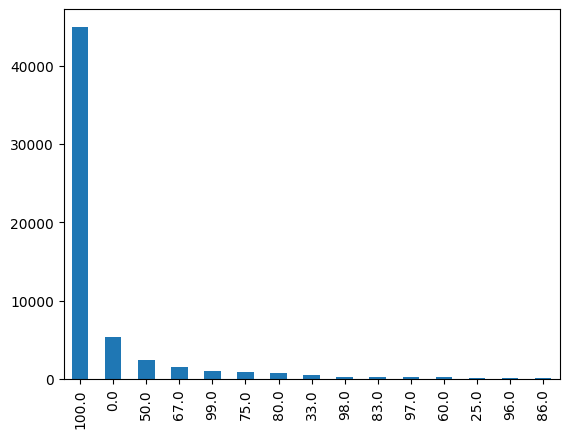

In [ ]:
def_chg_perc = df['Max_Perc_Def_Chg_Pending'].value_counts()[df['Max_Perc_Def_Chg_Pending'].value_counts() >= 100]
def_chg_perc.plot(kind='bar')

Now lets handle "N_Default_L3m" column missing values: 

In [ ]:
df['N_PosBkt_L3m'].isna().sum()

5338

In [ ]:
df['N_PosBkt_L3m'].value_counts()

0.0    74985
1.0      857
2.0       72
3.0        1
Name: N_PosBkt_L3m, dtype: int64

In [ ]:
df['N_PosBkt_L3m'][df['Target_Flag'] == 0].value_counts()

0.0    66176
1.0      587
2.0       47
3.0        1
Name: N_PosBkt_L3m, dtype: int64

In [ ]:
df['N_PosBkt_L3m'][df['Target_Flag'] == 1].value_counts()

0.0    8809
1.0     270
2.0      25
Name: N_PosBkt_L3m, dtype: int64

In [ ]:
df['Target_Flag'][df['N_PosBkt_L3m'].isna()].value_counts()

0    4658
1     680
Name: Target_Flag, dtype: int64

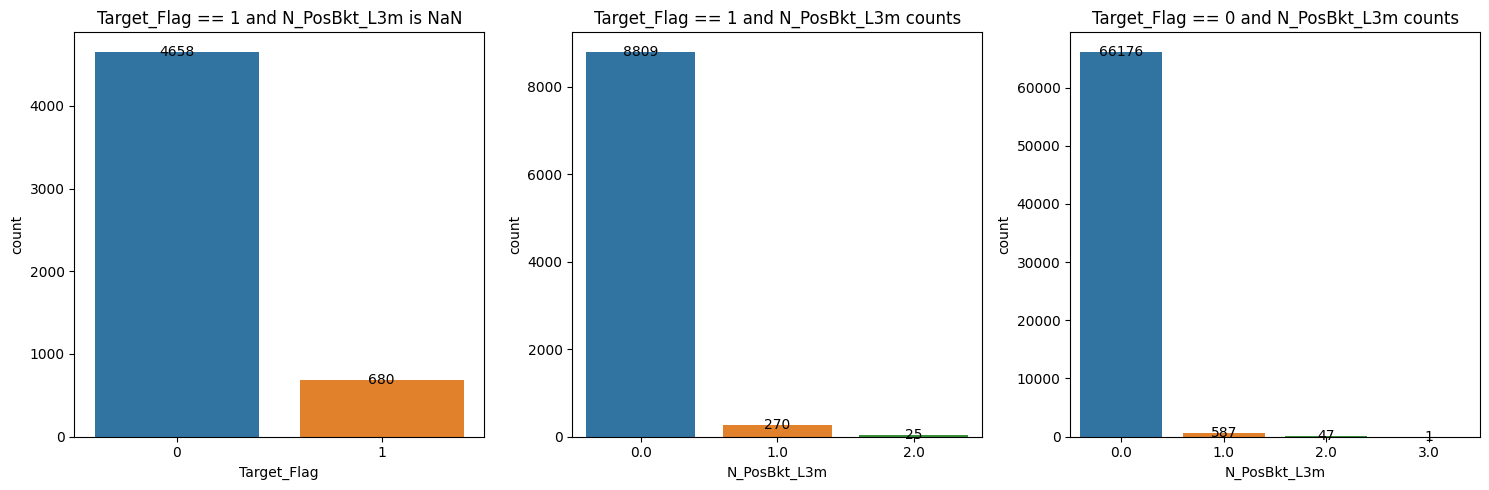

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Target_Flag == 1 and N_PosBkt_L3m is NaN
sns.countplot(data=df[df['N_PosBkt_L3m'].isna()], x='Target_Flag', ax=axes[0])
axes[0].set_title('Target_Flag == 1 and N_PosBkt_L3m is NaN')
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Plot 2: Target_Flag == 1 and N_PosBkt_L3m counts
sns.countplot(data=df[df['Target_Flag'] == 1], x='N_PosBkt_L3m', ax=axes[1])
axes[1].set_title('Target_Flag == 1 and N_PosBkt_L3m counts')
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Plot 3: Target_Flag == 0 and N_PosBkt_L3m counts
sns.countplot(data=df[df['Target_Flag'] == 0], x='N_PosBkt_L3m', ax=axes[2])
axes[2].set_title('Target_Flag == 0 and N_PosBkt_L3m counts')
for p in axes[2].patches:
    axes[2].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()



We see that for missing values defaults are 680 and not defaults are 4658. Which is a proportionate distribution with whole training data.
* It may also correspond to people who recently took the loan. (Less than 3 months ago)<br>
 Anyway since it merely affects 6% of the data so we can test it out with imputing 0, if needed we can try some other methods.
---

Now remaining two columns with missing values are:
1. Max_DPD_L3m
2. Max_Loan_Balance_Others

In [ ]:
df['Max_DPD_L3m'].isna().sum()

243

In [ ]:
df['Target_Flag'][df['Max_DPD_L3m'].isna()].value_counts()

0    219
1     24
Name: Target_Flag, dtype: int64

In [ ]:
value_counts_grouped = df.groupby(['Max_DPD_L3m', 'Target_Flag']).size().reset_index(name='count')
value_counts_grouped

,Max_DPD_L3m,Target_Flag,count
0,0.0,0,23603
1,0.0,1,1913
2,1.0,0,917
3,1.0,1,90
4,2.0,0,952
5,2.0,1,88
6,3.0,0,1143
7,3.0,1,73
8,4.0,0,1772
9,4.0,1,138


In [ ]:
df['Target_Flag'][df['Max_DPD_L3m'] == 0.0].value_counts()

0    47283
1     4183
Name: Target_Flag, dtype: int64

In [ ]:
df['Target_Flag'][df['Max_DPD_L3m'] > 0.0].value_counts()

0    47647
1     7847
Name: Target_Flag, dtype: int64

We see that about 7.5% of customer defaulted when their days delay in payment was 0.
Also about 14.12% of people defaulted otherwise.

One interesting way to solve this problem would be imputing 0.0 in case target flag is 0 and  15.0 or higher when target flag is 1.

<Axes: >

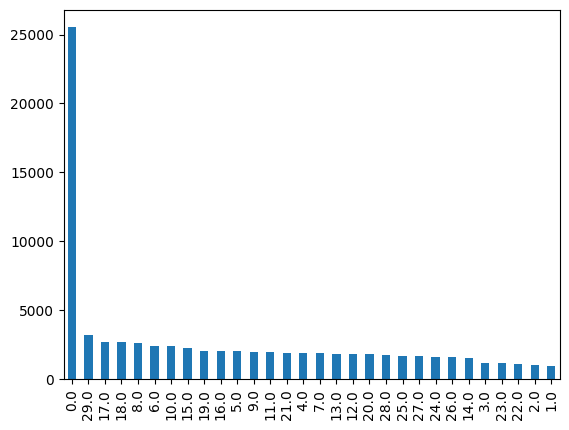

In [ ]:
df['Max_DPD_L3m'].value_counts().plot(kind='bar')

In [ ]:
from random import randint

df['Max_DPD_L3m'].fillna(0.0 if (df['Target_Flag'] == 0).all() else np.random.randint(15, 30), inplace=True)


Now for column "Max_Loan_Balance_Others":

In [ ]:
df['Max_Loan_Balance_Others'].isna().sum()

341

In [ ]:
df['Target_Flag'][df['Max_Loan_Balance_Others'].isna()].value_counts()

0    298
1     43
Name: Target_Flag, dtype: int64

In [ ]:
df['Max_Loan_Balance_Others'].describe()

count    8.091200e+04
mean     1.462583e+05
std      4.509210e+05
min     -5.425000e+03
25%      9.992000e+03
50%      1.999900e+04
75%      1.100060e+05
max      6.553632e+07
Name: Max_Loan_Balance_Others, dtype: float64

We see there are some negative values in this column lets make them positive.

In [ ]:
df['Max_Loan_Balance_Others'] = df['Max_Loan_Balance_Others'].abs()

In [ ]:
df['Max_Loan_Balance_Others'].describe()

count    8.091200e+04
mean     1.462589e+05
std      4.509208e+05
min      0.000000e+00
25%      9.992000e+03
50%      1.999900e+04
75%      1.100060e+05
max      6.553632e+07
Name: Max_Loan_Balance_Others, dtype: float64

Let's compare different percentile with Target_Flag

In [ ]:
df['Target_Flag'][df['Max_Loan_Balance_Others']<9992].value_counts()

0    17801
1     2403
Name: Target_Flag, dtype: int64

12%, 12.5%, 12.42%, 10.9%
12.32, 

In [ ]:
df['Target_Flag'][df['Max_Loan_Balance_Others']<19999].value_counts()

0    35394
1     5036
Name: Target_Flag, dtype: int64

In [ ]:
df['Target_Flag'][(9992 < df['Max_Loan_Balance_Others']) & (df['Max_Loan_Balance_Others'] > 19999)].value_counts()

0    35682
1     4686
Name: Target_Flag, dtype: int64

In [ ]:
df['Target_Flag'][(19999 < df['Max_Loan_Balance_Others']) & (df['Max_Loan_Balance_Others'] > 110006)].value_counts()


0    18024
1     2204
Name: Target_Flag, dtype: int64

In [ ]:
df['Target_Flag'][df['Max_Loan_Balance_Others']>110006].value_counts()

0    18024
1     2204
Name: Target_Flag, dtype: int64

In [ ]:
df['Target_Flag'][df['Max_Loan_Balance_Others']== 0.0].value_counts()

0    1787
1     212
Name: Target_Flag, dtype: int64

1. There are zeroes in this column which suggest that column includes people with zero loan. <br>
2. There are very less null values it may quite simply mean that these customer doesn't even have a bank account in other banks.
3. Distribution of target flag over different range of percentile is more or less similar.
4. Moreover distribution of target flag is also quite similar in case when loan balance with others is 0.

 -----> In any case filling these null values with 0 will do no harm.

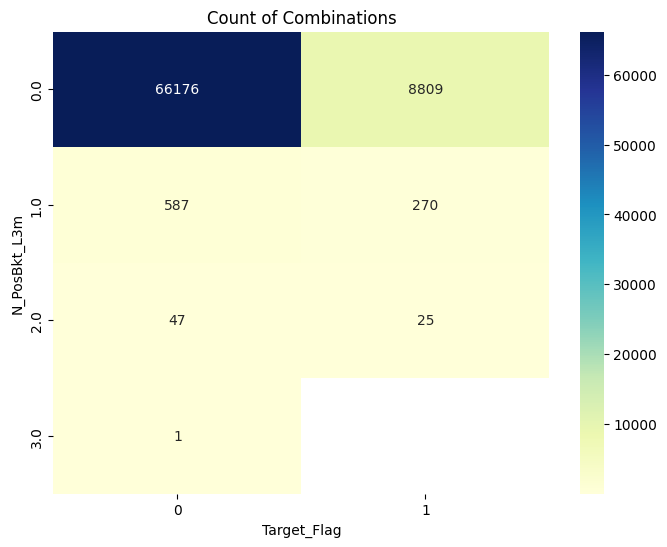

In [ ]:
value_counts_grouped = df.groupby(['N_PosBkt_L3m', 'Target_Flag']).size().reset_index(name='count')

pivot_table = value_counts_grouped.pivot('N_PosBkt_L3m', 'Target_Flag', 'count')


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Count of Combinations")
plt.show()

In [ ]:
col

Index(['N_Default_L3m', 'Branch_Code', 'Max_Utilization',
       'Max_Perc_Def_Chg_Pending', 'N_Family_Member',
       'Max_Ratio_OC_Pending_POS', 'N_PosBkt_L3m', 'CoAp_Income',
       'Ever_Default_L12M', 'Perc_Paymode_Online', 'Perc_Repay_Fail',
       'Birth_Year', 'Max_DPD_L3m', 'Perc_Paymode_Cheq_Fail', 'Age',
       'Total_Field_Trails', 'Total_Resolved', 'N_Enq_L9m',
       'Max_Loan_Balance_Others', 'N_WorkEx_Yr', 'Target_Flag'],
      dtype='object')

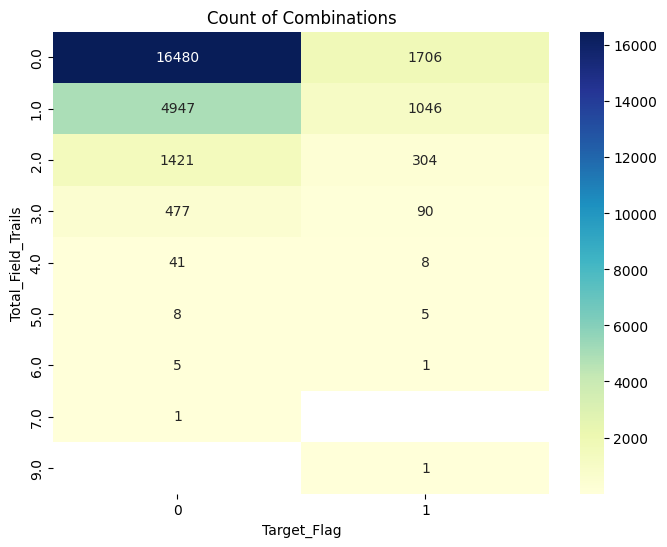

In [ ]:
value_counts_grouped = df.groupby(['Total_Field_Trails', 'Target_Flag']).size().reset_index(name='count')

pivot_table = value_counts_grouped.pivot('Total_Field_Trails', 'Target_Flag', 'count')


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Count of Combinations")
plt.show()

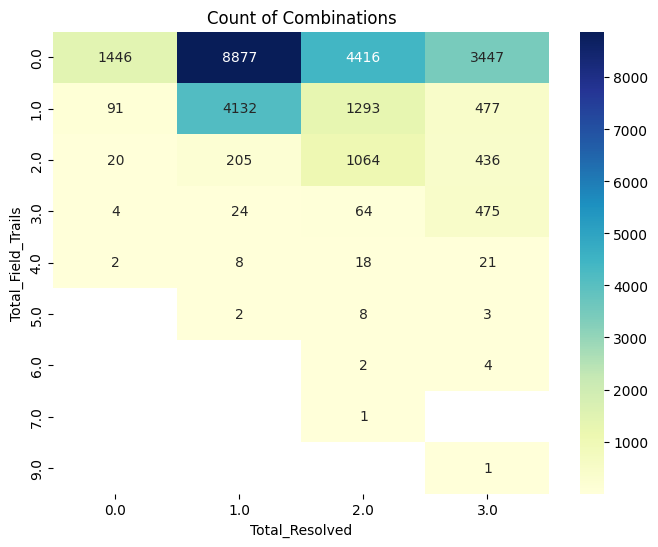

In [ ]:
value_counts_grouped = df.groupby(['Total_Field_Trails', 'Total_Resolved']).size().reset_index(name='count')

pivot_table = value_counts_grouped.pivot('Total_Field_Trails', 'Total_Resolved', 'count')


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Count of Combinations")
plt.show()

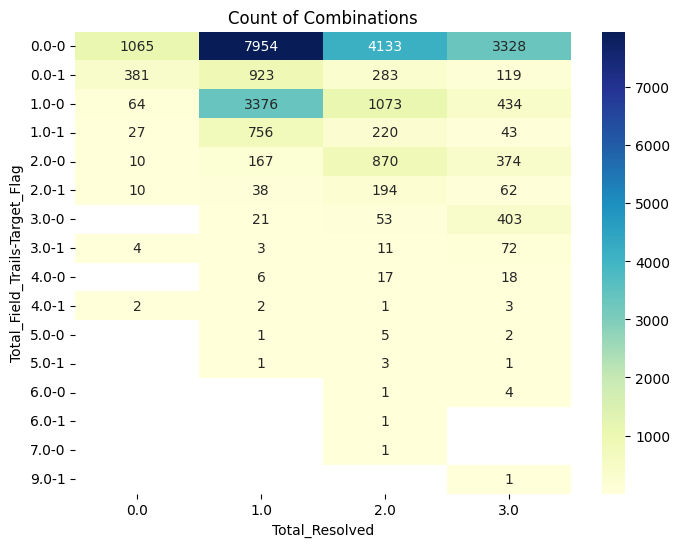

In [ ]:
value_counts_grouped = df.groupby(['Total_Field_Trails', 'Target_Flag', 'Total_Resolved']).size().reset_index(name='count')

pivot_table = value_counts_grouped.pivot(index=['Total_Field_Trails', 'Target_Flag'], columns='Total_Resolved',values='count')


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title("Count of Combinations")
plt.show()

In [ ]:
def value_wise_defaulter_percentage(df, col):
    new_df = pd.DataFrame(columns=['Value', 'Percentage of Defaulter'])
    
    for value in df[col]:
        default_cnt = df[(df[col] == value) & (df['Target_Flag']== 1)].shape[0]
        total_cnt = df[df[col] == value].shape[0]
        new_df = new_df.append({'Value' : value , 'Percentage of Defaulter' : (default_cnt*100/total_cnt)}, ignore_index=True)
    return new_df.sort_values(by='Percentage of Defaulter', ascending=False)

In [ ]:
filtered_df = df[(df['Max_Ratio_OC_Pending_POS'] >= 0) & (df['Max_Ratio_OC_Pending_POS'] <= 1)]


,N_Default_L3m,Branch_Code,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,Max_Ratio_OC_Pending_POS,N_PosBkt_L3m,CoAp_Income,Ever_Default_L12M,Perc_Paymode_Online,...,Birth_Year,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,Total_Field_Trails,Total_Resolved,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
Customer_No,,,,,,,,,,,,,,,,,,,,,
13,3,25432,64,100.0,4,0.214887,0.0,NaN,Yes,0.500000,...,1996,28.0,1.000000,27,NaN,NaN,0,6472.0,4,1
26,3,62878,39,83.0,4,0.673448,0.0,NaN,Yes,0.428571,...,1984,28.0,0.750000,39,NaN,0.0,0,205125.0,-7,0
27,2,16764,40,82.0,4,0.192158,0.0,NaN,Yes,0.333333,...,1995,29.0,0.666667,28,NaN,0.0,0,570525.0,8,1
29,3,60182,68,67.0,0,0.110243,1.0,67243.0,Yes,0.285714,...,1973,14.0,0.600000,50,NaN,1.0,0,7861.0,24,0
34,3,62390,64,100.0,-4,0.225771,0.0,NaN,Yes,0.375000,...,1993,28.0,0.600000,30,1.0,0.0,0,82058.0,-4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81018,1,54909,100,100.0,7,0.052872,NaN,NaN,Yes,0.250000,...,1984,26.0,0.500000,39,NaN,NaN,0,8800.0,5,0
81052,1,60825,100,100.0,4,0.046532,NaN,NaN,Yes,0.250000,...,1983,26.0,0.500000,40,NaN,NaN,0,10205.0,20,0
81173,1,69755,100,100.0,9,0.021280,NaN,NaN,Yes,0.000000,...,1976,29.0,0.500000,47,NaN,NaN,0,21866.0,19,0


<Axes: ylabel='Density'>

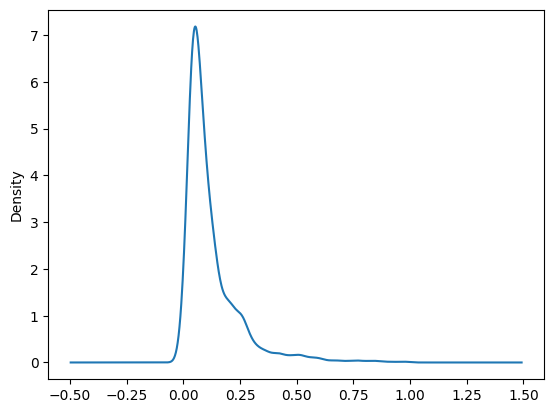

In [ ]:
filtered_df['Max_Ratio_OC_Pending_POS'].plot(kind='kde')

<Axes: >

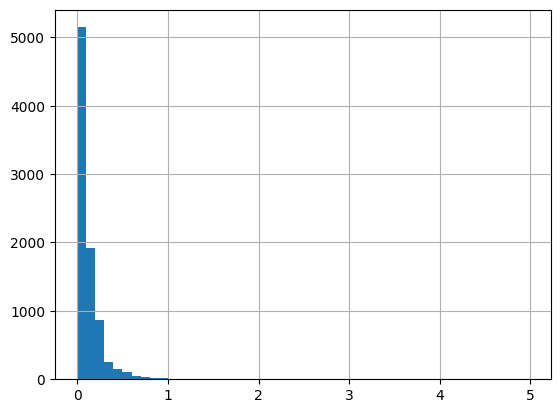

In [ ]:
df['Max_Ratio_OC_Pending_POS'].hist(bins=50)

In [ ]:
count = df['Max_Ratio_OC_Pending_POS'].value_counts()
count

0.000000    249
0.255264     37
0.110603     25
0.088956     21
0.106227     20
           ... 
0.265586      1
0.076857      1
0.024070      1
0.217585      1
0.043705      1
Name: Max_Ratio_OC_Pending_POS, Length: 6182, dtype: int64

-----> Both test and train data have similar distribution of missing values.

---

Identifying Numerical Datatypes Columns

In [ ]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

df[numerical_features].head()

Number of numerical variables:  20


,N_Default_L3m,Branch_Code,Max_Utilization,Max_Perc_Def_Chg_Pending,N_Family_Member,Max_Ratio_OC_Pending_POS,N_PosBkt_L3m,CoAp_Income,Perc_Paymode_Online,Perc_Repay_Fail,Birth_Year,Max_DPD_L3m,Perc_Paymode_Cheq_Fail,Age,Total_Field_Trails,Total_Resolved,N_Enq_L9m,Max_Loan_Balance_Others,N_WorkEx_Yr,Target_Flag
Customer_No,,,,,,,,,,,,,,,,,,,,
1,3,61749,38,100.0,5,NaN,0.0,NaN,0.285714,0.428571,1977,19.0,0.750,46,NaN,NaN,0,5527.0,15,0
2,1,30831,68,100.0,1,NaN,0.0,NaN,0.000000,0.200000,1990,2.0,0.500,33,NaN,NaN,0,12104.0,2,0
3,1,56708,39,50.0,-3,NaN,0.0,NaN,0.200000,0.200000,1995,25.0,1.000,28,NaN,0.0,1,153179.0,8,0
4,0,43551,76,NaN,0,NaN,0.0,NaN,0.000000,0.000000,1997,0.0,NaN,26,NaN,NaN,2,181589.0,6,0
5,3,15287,23,33.0,11,NaN,0.0,NaN,0.250000,0.250000,1995,19.0,0.375,28,NaN,NaN,1,10661.0,8,0


Finding Rest of the Columns

In [ ]:
for col in df.columns:
    if col not in numerical_features:
        print(col)

Ever_Default_L12M


In [ ]:
df['Ever_Default_L12M'].unique()

array(['Yes', 'No'], dtype=object)

Changing "Yes" and "No" to 0 and 1 respectively

In [ ]:
df['Ever_Default_L12M'] = df['Ever_Default_L12M'].replace({'Yes': 1, 'No': 0})

In [ ]:
def value_wise_defaulter_percentage(df, col):
    new_df = pd.DataFrame(columns=['Value', 'Percentage of Defaulter'])
    
    for value in df[col].unique():
        default_cnt = df[(df[col] == value) & (df['Target_Flag']== 1)].shape[0]
        total_cnt = df[df[col] == value].shape[0]
        new_df = new_df.append({'Value' : value , 'Percentage of Defaulter' : (default_cnt*100/total_cnt)}, ignore_index=True)
    return new_df.sort_values(by='Percentage of Defaulter', ascending=False)